[Olist Kaggle Dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv)

In [ ]:
# __file__ = "1.0-pr-initial-data-exploration.ipynb"
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'), 'raw_data')

# files_names = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv')]
# dataframes = {}
# for file_name in files_names:
#     table_name = file_name.replace("olist_", "").replace("_dataset", "").replace(".csv","")
#     dataframes[table_name] = pd.read_csv(os.path.join(DATA_DIR, file_name))
#     print(f"Loading {table_name}")    

# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region

_delivered orders only_

<font color='gray' text-align='justify'>
    <strong>Note</strong>: I am familiar with SQL. However, here I decided to manipulate the data with the help of python, since I feel more comfortable with it. 
    <br>But <strong>to improve my SQL skills I'll challenge myself to use only SQL. Here's the <a href='https://shap.readthedocs.io/en/latessc' target='_blanck'>1.1-pr-data-analysis-full-postgresql-challenge notebook</a>.</strong>
</font>

# 0.0 Imports

In [3]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

from datetime import date
from functools import reduce

import dotenv
import os
from IPython.display import Image

In [4]:
# Settings
dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

__file__ = "1.0-pr-data-analysis-postgresql.ipynb"
THIS_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))
DASHBOARD_DATA_DIR = os.path.join(DATA_DIR, "business_questions_insights_dashboard_data")

NOWADAY = date(2018,10,1) # PROJECT STARTING ASSUMED DATE

## 0.1 Helper Classes

In [5]:
class QueryBuilder:
    def __init__(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        self.last_query_value = ''

    def select(self, select_arg):
        self.select_value = select_arg
        return self

    def from_table(self, from_arg):
        self.from_table_name = from_arg
        return self

    def where(self, where_arg):
        self.where_value = where_arg
        return self

    def groupby(self, groupby_args):
        self.groupby_value = groupby_args
        return self
    
    def having(self, having_value):
        self.having_value = having_value
    
    def limit(self, limit_args):
        self.limit_value = limit_args
        return self
    
    def reset(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.having_value = ''
        return self
    
    def last_query(self):
        return self.last_query_value

    def build(self, reset=True):
        where_clause = ''
        groupby_clause = ''
        having_clause =''
        limit_clause = ''
        
        if self.where_value:
            where_clause = f'WHERE  {self.where_value}'
        if self.groupby_value:
            groupby_clause = f'GROUP BY {self.groupby_value}'
        if self.limit_value:
            limit_clause = f'LIMIT {self.limit_value}'
        if self.having_value:
            having_clause = f'HAVING {self.having_value}'

        self.last_query_value = f"""
           SELECT {self.select_value}
           FROM   {self.from_table_name}
           {where_clause}
           {groupby_clause}
           {having_clause}
           {limit_clause};
        """
        
        if reset:
            self.reset()
        
        return self.last_query_value
    
    
class PostegreSQL:
    def __init__(self, host="localhost", user="postgres", password="********", database="postgres"):
        self.conn = psycopg2.connect(host=host, user=user, password=password, database=database)
        self.cursor = self.conn.cursor()
        
    def execute(self, query):
        self.cursor.execute(query)
        return [table for table in self.cursor.fetchall()]
    
    def columns(self, table_name):
        self.cursor.execute(F"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'""" )
        return [table[0] for table in self.cursor.fetchall()]
    
    def tables(self):
        self.cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
        return [table for table in self.cursor.fetchall()]
    
    def rollback(self):
        self.cursor.execute("ROLLBACK;")

## 0.2  Helper Functions

In [207]:
def db_mer_schema():
    return Image( '../images/mer.png' ) 


def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)
    
    
def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()
    

def fig(x=15, y=5):
    plt.figure(figsize=(x,y))
    
    
    
def map_regions(state):
    regions = {
        'north': ['AM','RR','AP','PA','TO','RO','AC'],
        'northeast': ['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'midwest': ['MT','MS','GO','DF'],
        'southeast': ['SP','RJ','ES','MG'],
        'south': ['PR','RS','SC']
    }
    for region, states in regions.items():
        if state in states:
            return region
        
        
# Business Questions.
        
def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    #display(nan_data_frame)
    return nan_data_frame

def missing_plot(data, nan_cols, no_nan_col, x=15, y=5, first_graph=True, second_graph=True):
    nan_cols.insert(0, no_nan_col)
    try:
        if first_graph:
            msno.matrix(data[nan_cols], figsize=(x, y))
            plt.show()
        if second_graph:
            msno.bar(data[nan_cols], figsize=(x, y))
            plt.show()
    except Exception as e:
        print(e)

def classify_seller(value, frequency):
    if value <= .5 and frequency <= .5:
        seller_category = "LOW VALUE LOW FREQUENCY"        
    elif value > .5 and frequency <= .5:
        seller_category = "HIGH VALUE"
    elif value <= .5 and frequency > .5:
        seller_category = "HIGH FREQUENCY"
    elif value > .9 and frequency > .9:
        seller_category = "SUPER PRODUCTIVE"
    else:
        seller_category = "PRODUCTIVE"
    
    return seller_category

def get_seller_status(months_since_enrollment, months_since_last_sale):
    if months_since_enrollment <= 2:
        status = "NEW SELLER"
    elif months_since_last_sale >= 10: 
        status = "INACTIVE"
    else:
        status = "ACTIVE"
    
    return status

## 0.3 Loading Data

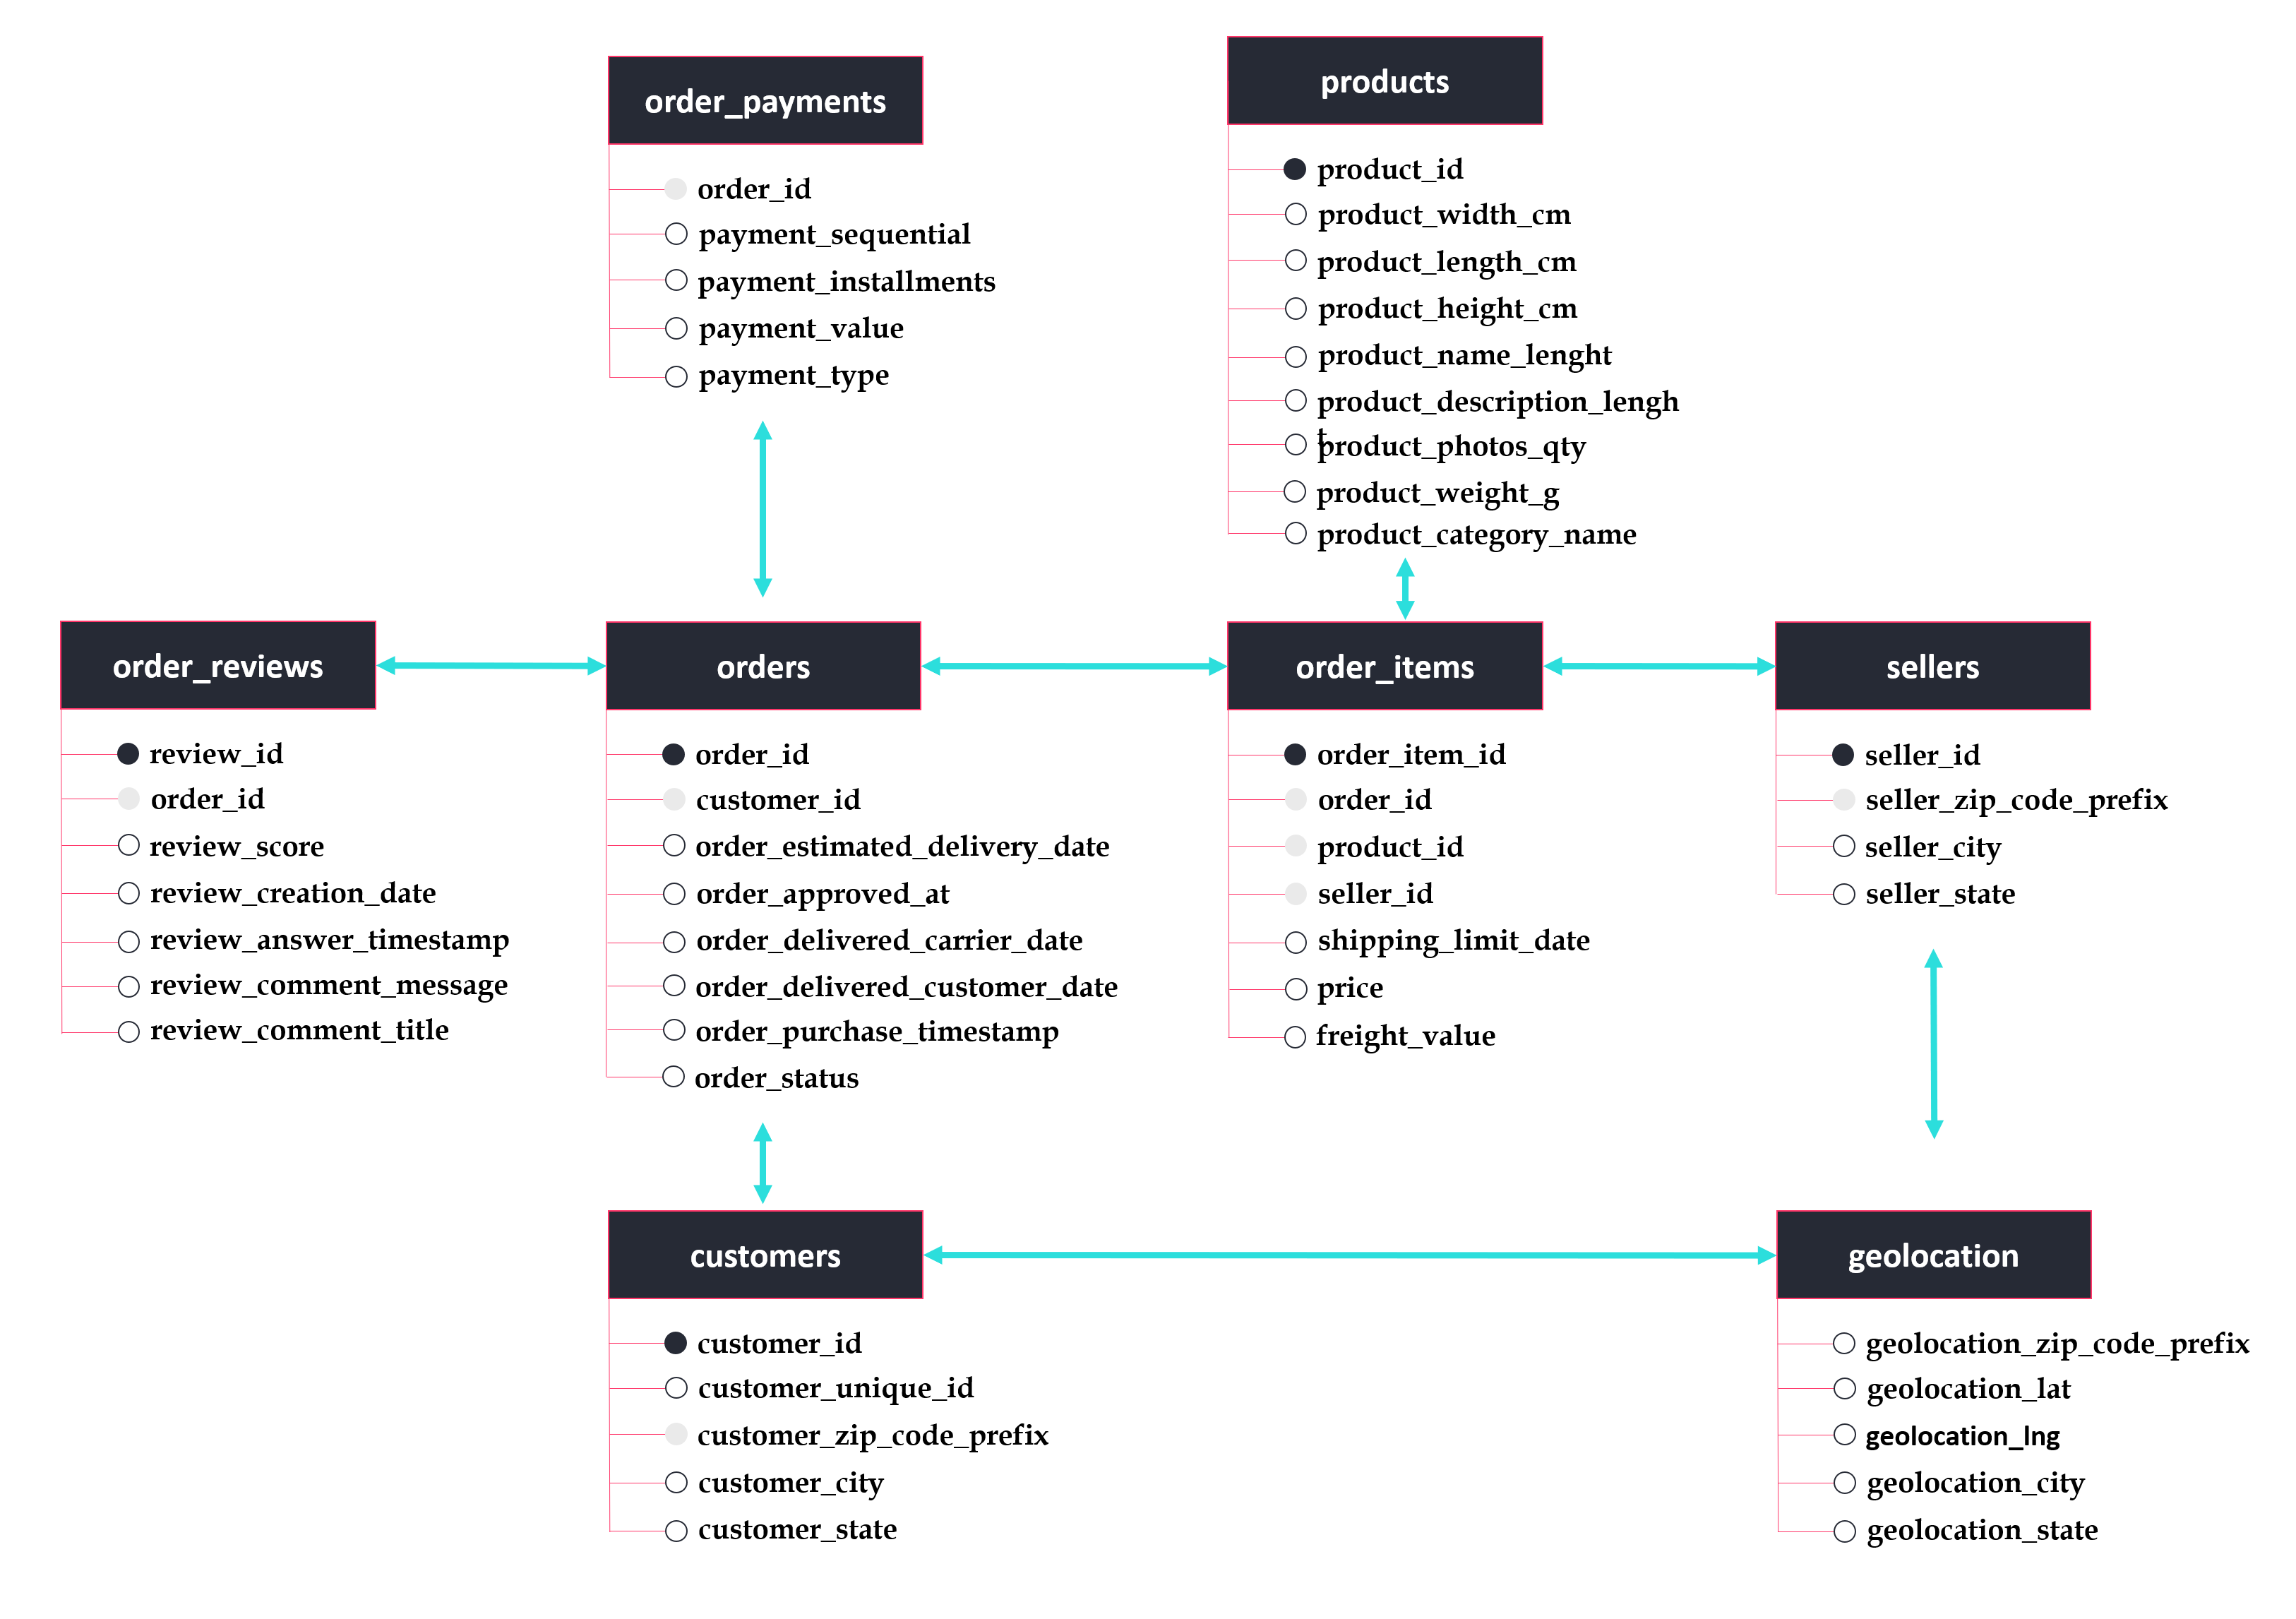

In [5]:
db_mer_schema()

<font  color='grey'>
    As my service was in stopped state somehow. "On windows, Just go to the 'Services'. Start/Restart the postgresql-X64 service".<br>
<a href='https://stackoverflow.com/questions/40532399/unable-to-connect-to-server-for-postgres' target='_blank'>stackoverflow</a>
</font>

In [7]:
db = PostegreSQL(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database="postgres")

In [8]:
query = QueryBuilder()

## 1.0 Dashboard Queries

Getting the data from PostgreSQL database and saving it to be used in the dashboard.

### 1.1 Total Sales

_from confirmed (delivered) orders_

In [8]:
query.select("MIN(order_purchase_timestamp), MAX(order_purchase_timestamp)").from_table("orders")
to_pandas(db.execute(query.build()),['first_purchase','last_purchase'])

,first_purchase,last_purchase
0,2016-09-04 21:15:19,2018-10-17 17:30:18


In [10]:
def _get_annual_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price)").\
                            from_table("orders LEFT JOIN order_items ON orders.order_id = order_items.order_id").\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

_get_annual_sales(2017)

,date,total_sales,month
0,2017-01-05,111798.36,Jan
1,2017-02-01,234223.40,Feb
2,2017-03-01,359198.85,Mar
3,2017-04-01,340669.68,Apr
4,2017-05-01,489338.25,May
5,2017-06-01,421923.37,Jun
6,2017-07-01,481604.52,Jul
7,2017-08-01,554699.70,Aug
8,2017-09-01,607399.67,Sep
9,2017-10-01,648247.65,Oct


In [11]:
year = 2018
annual_sales = _get_annual_sales(year).dropna()

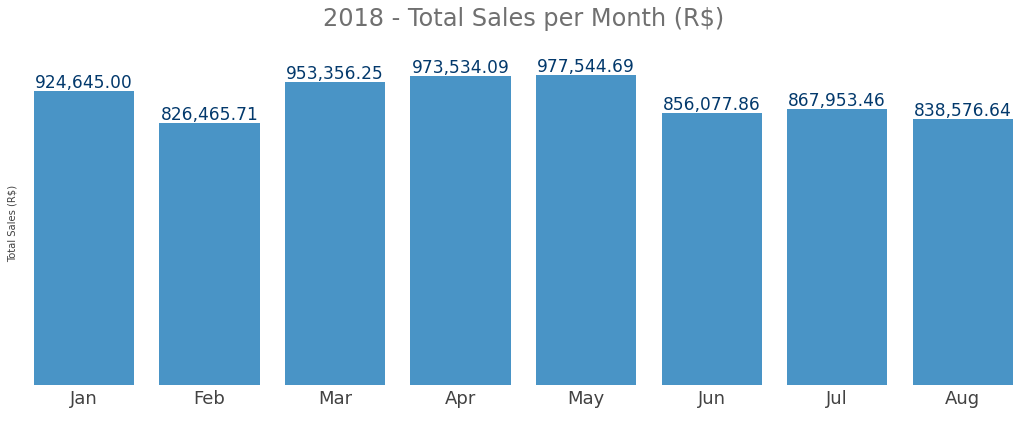

In [12]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
fig(18,6)
sns.barplot(data=annual_sales, x='month', y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"{year} - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("{:,.2f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

In [13]:
# Saving for PowerBi Dashboard
annual_sales.drop(columns='month').to_csv(os.path.join(DASHBOARD_DATA_DIR, "monthly_sales_2018.csv"), index=False)

### 1.2 Sales per Region

There is no data about regions in the database, but we can use states to map them.

In [14]:
def _get_regional_sales(year):
    sales_per_month = pd.DataFrame()
    for month in range(1, 13):

        intial_date = str(date(year, month, 1))
        if month == 12:
            month = 0
            year += 1
        final_date = str(date(year, month+1, 1))
        total_sales_query = query.select("date(MIN(order_purchase_timestamp)), SUM(price), customer_state").\
                            from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                         LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                            where(f'''order_status='delivered' and 
                                  order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')''').\
                            groupby("customers.customer_state").\
                            build()

        sales_per_month = pd.concat([sales_per_month,to_pandas(db.execute(total_sales_query),['date','total_sales','state'])], axis=0)
        sales_per_month['date'] = pd.to_datetime(sales_per_month['date'])
        sales_per_month['month'] = sales_per_month['date'].dt.strftime('%b')
        
    return sales_per_month.reset_index(drop=True)

_get_regional_sales(2017).head(2)

,date,total_sales,state,month
0,2017-01-21,589.60,AC,Jan
1,2017-01-25,393.97,AL,Jan


In [15]:
region_sales_per_month = _get_regional_sales(2018)

In [16]:
region_sales_per_month['region'] = region_sales_per_month.state.apply(map_regions)

In [17]:
region_sales_per_month.groupby("region").agg(['sum','mean','median']).round(2)

total_sales                      
                  sum       mean     median
region                                     
midwest     451261.13   14101.91   13309.95
north       161528.92    2936.89    1811.80
northeast   785140.40   10904.73    6866.88
south      1033757.65   43073.24   44046.22
southeast  4786465.60  149577.05  108298.86

**Saving Data to use in PowerBi Dashboard**

In [19]:
def _monthly_sales_per_region_to_df(region_name):  
    sales = region_sales_per_month.groupby(['region','date']).sum().loc[[region_name]].values
    sales_dates = region_sales_per_month.groupby(['region','date']).sum().loc[[region_name]].index.get_level_values("date")
    return pd.concat([pd.Series(sales_dates), pd.Series(sales.ravel(), name='total_sales')], axis=1)

**midwest**

In [20]:
midwest_sales_df = _monthly_sales_per_region_to_df('midwest')
midwest_sales_df.set_index("date").T

date,2018-01-01,2018-01-03,2018-02-01,2018-02-02,2018-03-01,2018-04-01,2018-04-03,2018-05-01,2018-06-01,2018-07-01,2018-07-02,2018-08-01
total_sales,44249.73,10535.7,47440.9,8172.69,53825.66,42901.31,11354.49,71272.76,52827.42,53788.38,6810.83,48081.26


In [21]:
midwest_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "midwest_monthly_sales_2018.csv"), index=False)

**south**

In [22]:
south_sales_df = _monthly_sales_per_region_to_df('south')
south_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "south_monthly_sales_2018.csv"), index=False)

**southeast**

In [23]:
southeast_sales_df = _monthly_sales_per_region_to_df('southeast')
southeast_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "southeast_monthly_sales_2018.csv"), index=False)

**northeast**

In [24]:
northeast_sales_df = _monthly_sales_per_region_to_df('northeast')
northeast_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "northeast_monthly_sales_2018.csv"), index=False)

**north**

In [25]:
north_sales_df = _monthly_sales_per_region_to_df('north')
north_sales_df.to_csv(os.path.join(DASHBOARD_DATA_DIR, "north_monthly_sales_2018.csv"), index=False)

### 1.3 Top 5 selling categories for each Region

In [26]:
intial_date = "2018-08-01"
final_date  = "2018-09-01"

In [27]:
sales_per_category_query = query.select("product_category_name, price, customer_state").\
                                 from_table('''orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                                               LEFT JOIN products ON products.product_id = order_items.product_id
                                               LEFT JOIN customers ON orders.customer_id = customers.customer_id''').\
                                 where(f"order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')").\
                                 build()
sales_per_category = to_pandas(db.execute(sales_per_category_query),['category','total_sales','state'])

In [28]:
sales_per_category['region'] = sales_per_category.state.apply(map_regions)

**Saving Data for Dashboard**

In [29]:
def _categories_sales_per_region_to_df(sales_per_category, region):
    sales = sales_per_category.groupby(["region", "category"]).sum().loc[[region]].\
            sort_values(by=['total_sales'], ascending=False).head(5).values
    categories = sales_per_category.groupby(["region", "category"]).sum().loc[[region]].\
                 sort_values(by=['total_sales'], ascending=False).head(5).index.get_level_values("category")
    categories = categories.str.replace("_"," ")
    return pd.concat([pd.Series(categories), pd.Series(sales.ravel(), name='total_sales')], axis=1)

def _save_sales_per_category_for_dashboard(sales_per_category, region):
    _categories_sales_per_region_to_df(sales_per_category, region).\
    to_csv(os.path.join(DASHBOARD_DATA_DIR, f"top_selling_categories_{region}.csv"), index=False)

In [30]:
_save_sales_per_category_for_dashboard(sales_per_category, "south")
_save_sales_per_category_for_dashboard(sales_per_category, "midwest")
_save_sales_per_category_for_dashboard(sales_per_category, "southeast")
_save_sales_per_category_for_dashboard(sales_per_category, "northeast")
_save_sales_per_category_for_dashboard(sales_per_category, "north")

## 2.0 Business Challenges

### 2.1 Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?

One form of evaluation is to give benefits based on productivity, using RFM (Recency, Frequency and Value) as main metrics. 

No. And, Yes, **there are sellers who deserves to be highlighted:**

- **Super Productive:** High Value High Frequency! Top 10% of sales and frequency. 
- **Productive:** lots of sales, high revenue. 
- **High Value:** few sales, but great revenue values.
- **High Frequency:** low revenue value, but many sales.
- **Low Value Low Frequency:** low revenue value and few sales.

Later We'll automate this pipeline, so that we'll be able to classify sellers in a certain period of time. Then, We'll be able to tell their rank whithin a specific moment in time.

_We can also work on a seller segmentation focused on product category and apply this pipeline below to rank the sellers according to their occupation field._

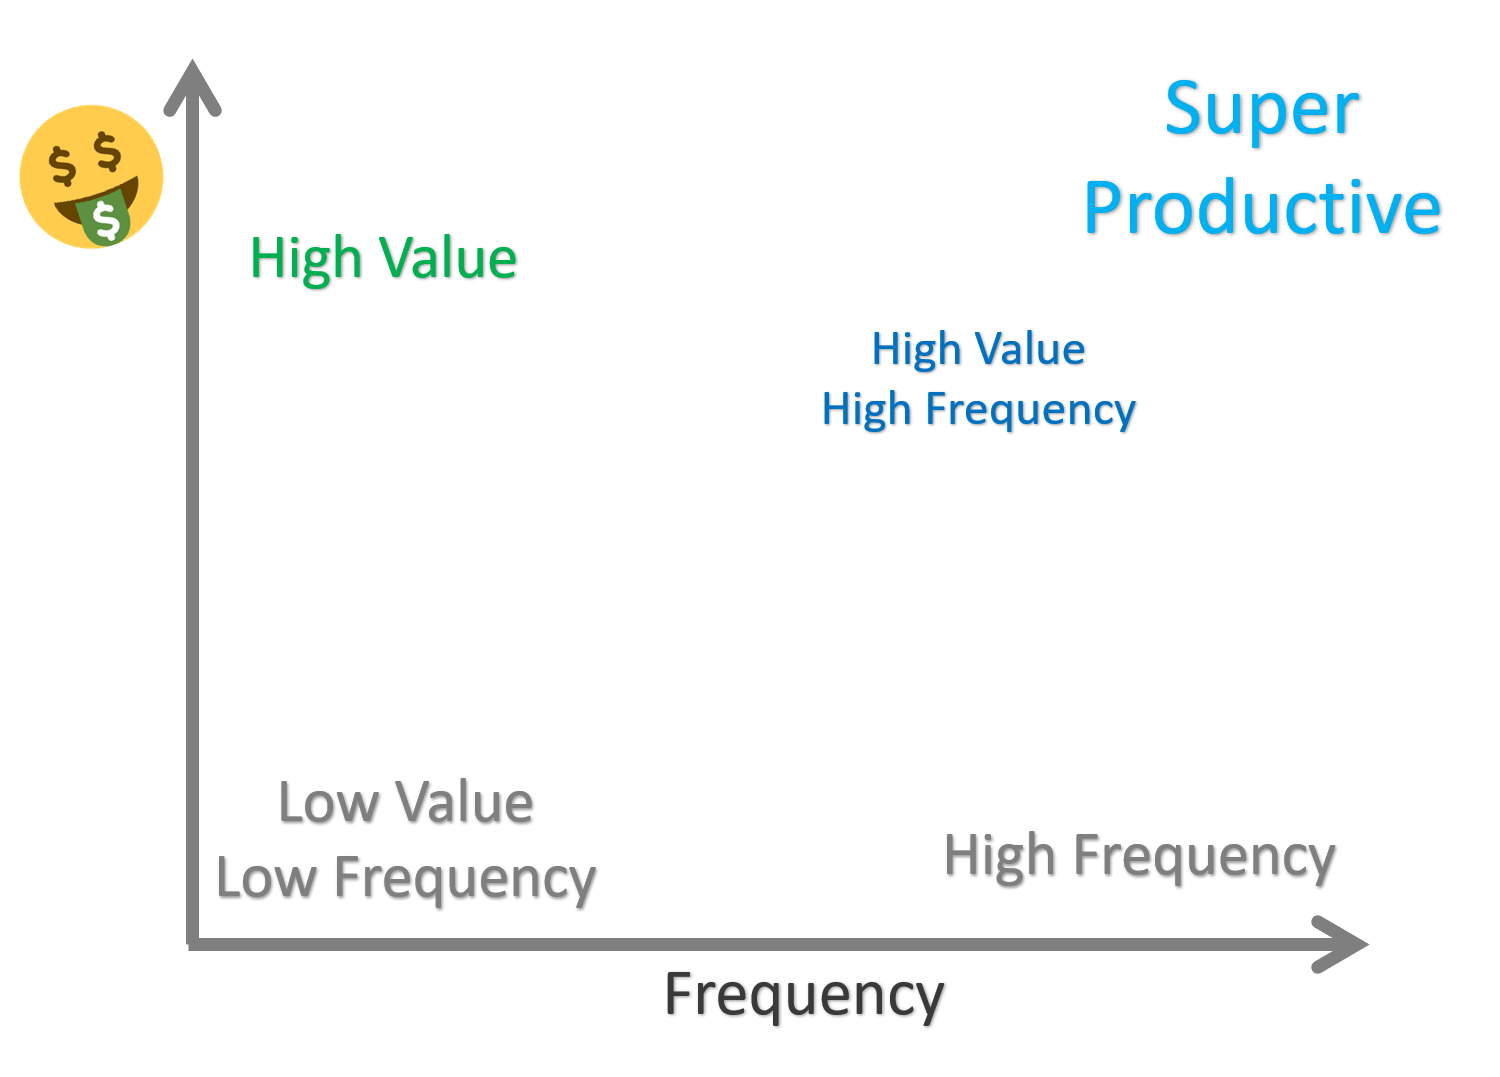

In [14]:
Image("../images/type_of_sellers.PNG", width=500)

In [9]:
q = '''
SELECT orders.order_id AS order_id,
       order_approved_at AS order_approved_at,
       order_purchase_timestamp as purchase_date,
       price AS price,
       order_items.seller_id AS seller_id
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
            LEFT JOIN sellers ON order_items.seller_id = sellers.seller_id'''
# WHERE order_purchase_timestamp >= DATE('2018-01-01')

cols = ['order_id','order_approved_at','purchase_date', 'price','seller_id']
sellers_sales_df = to_pandas(db.execute(q), cols)

In [10]:
write_query("../sql_queries/sellers_segment_pre_abt", q)

**Less than 1% missing values and all of them in the same rows. Let's just drop them.**

In [11]:
describe_data(sellers_sales_df)

Shape: (113425, 5)
Duplicates: True


,data_types,nan_count,nan_percentage
order_id,object,0,0.000000
order_approved_at,datetime64[ns],161,0.141944
purchase_date,datetime64[ns],0,0.000000
price,float64,775,0.683271
seller_id,object,775,0.683271


Shape: (113425, 5)
Duplicates: True


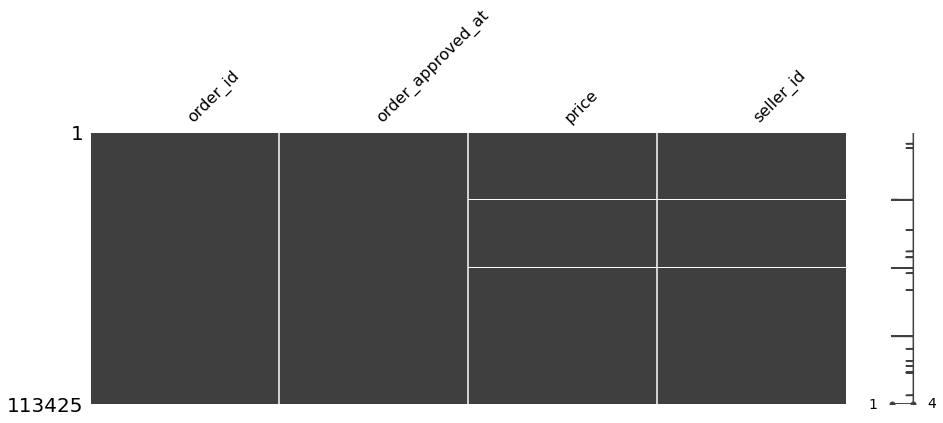

In [12]:
nan_cols = list(describe_data(sellers_sales_df).query('nan_percentage > 0').index)
missing_plot(sellers_sales_df, nan_cols, "order_id", second_graph=False)

In [13]:
sellers_sales_df.dropna(inplace=True)

### RFV Table

In [17]:
# Value*
total_revenue = sellers_sales_df.groupby("seller_id")["price"].sum()
total_revenue.name = "total_revenue"

# sales_quantity "False Frequency"
orders_quantity = sellers_sales_df.groupby("seller_id")["order_id"].count()    
orders_quantity.name = "orders_quantity"

distinct_products_sold = sellers_sales_df.groupby("seller_id")["order_id"].nunique() 
distinct_products_sold.name = "distinct_products_sold"

# Recency*
days_since_last_sale = pd.to_datetime(sellers_sales_df.groupby("seller_id")["order_approved_at"].max()).dt.date.apply(lambda x: NOWADAY - x)
days_since_last_sale.name = "days_since_last_sale"

# days in the database "Enrollment"
days_since_first_sale = pd.to_datetime(sellers_sales_df.groupby("seller_id")["order_approved_at"].min()).dt.date.apply(lambda x: NOWADAY - x)
days_since_first_sale.name = "days_since_first_sale"

In [18]:
dfs = [total_revenue, orders_quantity, distinct_products_sold, days_since_last_sale, days_since_first_sale]
sellers_sgmt_abt = reduce(lambda left,right: pd.merge(left,right,on='seller_id'), dfs)

sellers_sgmt_abt.head(3)

,total_revenue,orders_quantity,distinct_products_sold,days_since_last_sale,days_since_first_sale
seller_id,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2685.00,3,3,348 days,369 days
001cca7ae9ae17fb1caed9dfb1094831,25080.03,239,200,81 days,604 days
001e6ad469a905060d959994f1b41e4f,250.00,1,1,55 days,55 days


### Analytical Base Table (sellers segmentation)

Let's focus on a monthly analysis instead of a daylily look.

And we can normalize the values using their percentile rank.

In [21]:
sellers_sgmt_abt['months_since_last_sale'] = days_since_last_sale.dt.days / 30
sellers_sgmt_abt['months_since_first_sale'] = days_since_first_sale.dt.days / 30

sellers_sgmt_abt['orders_per_month'] = sellers_sgmt_abt['orders_quantity'] / sellers_sgmt_abt['months_since_first_sale']
sellers_sgmt_abt['revenue_per_month'] = sellers_sgmt_abt['total_revenue'] / sellers_sgmt_abt['months_since_first_sale']

sellers_sgmt_abt['value_rank'] = sellers_sgmt_abt['revenue_per_month'].rank(pct=True) 
sellers_sgmt_abt['frequency_rank'] = sellers_sgmt_abt['orders_per_month'].rank(pct=True)

Now We can classify each seller based on his position in the rank.

In [22]:
sellers_sgmt_abt['value_frequency_segment'] = sellers_sgmt_abt.\
apply(lambda df: classify_seller(df['value_rank'], df['frequency_rank']), axis=1)

sellers_sgmt_abt['seller_status'] = sellers_sgmt_abt.\
apply(lambda df: get_seller_status(df['months_since_first_sale'], df['months_since_last_sale']), axis=1)

Most of low value low frequency sellers are more than 10 months without selling.

# ADD LEGEND LEGEND LEGEND

In [223]:
cmap_ = {
        'HIGH VALUE': "#2ca02c",
        'SUPER PRODUCTIVE': "#ff7f0e",
        'PRODUCTIVE': "#1f77b4",
        'LOW VALUE LOW FREQUENCY': "#d62728",
        'HIGH FREQUENCY': "#9467bd"
    }

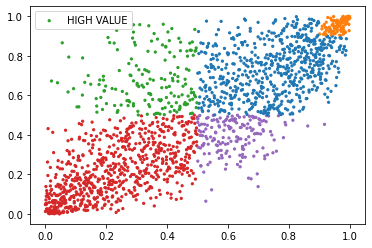

In [239]:
plt.scatter(sellers_sgmt_abt['frequency_rank'], sellers_sgmt_abt['value_rank'],
                            c=sellers_sgmt_abt['value_frequency_segment'].map(cmap_), s=5)
plt.legend(cmap_)

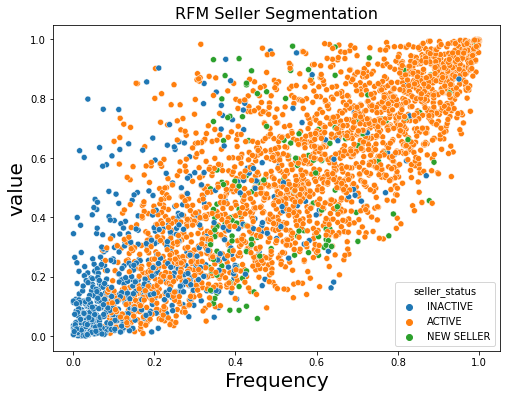

In [46]:
fig(8,6)
plt.title("RFM Seller Segmentation", size=16)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_sgmt_abt, x='frequency_rank', y='value_rank', hue='seller_status');

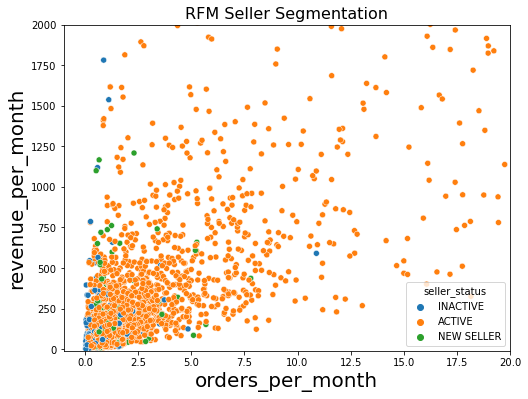

In [47]:
fig(8,6)
plt.title("RFM Seller Segmentation",  size=16)
plt.xlabel('orders_per_month', size=20)
plt.ylabel('revenue_per_month', size=20)
plt.ylim(-10, 2000)
plt.xlim(-1, 20)
sns.scatterplot(data=sellers_sgmt_abt, x='orders_per_month', y='revenue_per_month', hue='seller_status');

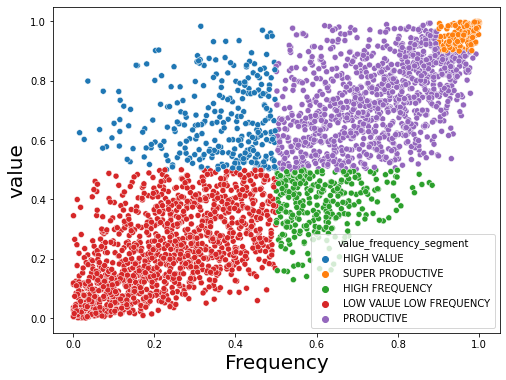

In [24]:
fig(8,6)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_sgmt_abt, x='frequency_rank', y='value_rank', hue='value_frequency_segment');

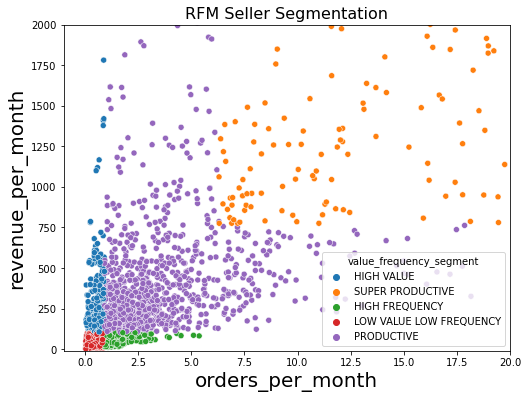

In [50]:
fig(8,6)
plt.title("RFM Seller Segmentation",  size=16)
plt.xlabel('orders_per_month', size=20)
plt.ylabel('revenue_per_month', size=20)
plt.ylim(-10, 2000)
plt.xlim(-1, 20)
sns.scatterplot(data=sellers_sgmt_abt, x='orders_per_month', y='revenue_per_month', hue='value_frequency_segment');

In [25]:
sellers_sgmt_abt['seller_status'].value_counts()

ACTIVE        2292
INACTIVE       652
NEW SELLER     151
Name: seller_status, dtype: int64

In [26]:
sellers_sgmt_abt['value_frequency_segment'].value_counts()

LOW VALUE LOW FREQUENCY    1256
PRODUCTIVE                 1069
HIGH FREQUENCY              291
HIGH VALUE                  291
SUPER PRODUCTIVE            188
Name: value_frequency_segment, dtype: int64

In [32]:
sellers_sgmt_abt.groupby("value_frequency_segment").agg(['mean','sum'])[['orders_per_month', 'revenue_per_month']]

orders_per_month              revenue_per_month  \
                                    mean          sum              mean   
value_frequency_segment                                                   
HIGH FREQUENCY                  1.547003   450.177922         64.210296   
HIGH VALUE                      0.580437   168.907297        281.281473   
LOW VALUE LOW FREQUENCY         0.334036   419.548991         29.958542   
PRODUCTIVE                      3.483319  3723.667798        443.362555   
SUPER PRODUCTIVE               21.044836  3956.429115       2596.988143   

                                        
                                   sum  
value_frequency_segment                 
HIGH FREQUENCY            18685.196025  
HIGH VALUE                81852.908730  
LOW VALUE LOW FREQUENCY   37627.929352  
PRODUCTIVE               473954.571294  
SUPER PRODUCTIVE         488233.770930

In [211]:
initial_date = date(2017,1,1)
final_date = date(2018,1,1)
time_shot = f'''\nWHERE order_purchase_timestamp BETWEEN DATE('{initial_date}') AND DATE('{final_date}')'''
seller_rank_query = read_query("../sql_queries/sellers_segment_pre_abt.sql") + time_shot
print(seller_rank_query)


SELECT orders.order_id AS order_id,
       order_approved_at AS order_approved_at,
       order_purchase_timestamp as purchase_date,
       price AS price,
       order_items.seller_id AS seller_id
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
            LEFT JOIN sellers ON order_items.seller_id = sellers.seller_id
WHERE order_purchase_timestamp BETWEEN DATE('2017-01-01') AND DATE('2018-01-01')


In [212]:
cols = ['order_id','order_approved_at','purchase_date', 'price','seller_id']
sellers_sales_df = to_pandas(db.execute(seller_rank_query), cols)
sellers_sales_df.dropna(inplace=True)

In [213]:
# Value*
total_revenue = sellers_sales_df.groupby("seller_id")["price"].sum()
total_revenue.name = "total_revenue"

# sales_quantity "False Frequency"
orders_quantity = sellers_sales_df.groupby("seller_id")["order_id"].count()    
orders_quantity.name = "orders_quantity"

distinct_products_sold = sellers_sales_df.groupby("seller_id")["order_id"].nunique() 
distinct_products_sold.name = "distinct_products_sold"

# Recency*
days_since_last_sale = pd.to_datetime(sellers_sales_df.groupby("seller_id")["order_approved_at"].max()).dt.date.apply(lambda x: final_date - x)
days_since_last_sale.name = "days_since_last_sale"

# days in the database "Enrollment"
days_since_first_sale = pd.to_datetime(sellers_sales_df.groupby("seller_id")["order_approved_at"].min()).dt.date.apply(lambda x: final_date - x)
days_since_first_sale.name = "days_since_first_sale"

In [214]:
dfs = [total_revenue, orders_quantity, distinct_products_sold, days_since_last_sale, days_since_first_sale]
sellers_sgmt_abt = reduce(lambda left,right: pd.merge(left,right,on='seller_id'), dfs)

In [215]:
sellers_sgmt_abt['months_since_last_sale'] = days_since_last_sale.dt.days / 30
sellers_sgmt_abt['months_since_first_sale'] = days_since_first_sale.dt.days / 30

sellers_sgmt_abt['orders_per_month'] = sellers_sgmt_abt['orders_quantity'] / sellers_sgmt_abt['months_since_first_sale']
sellers_sgmt_abt['revenue_per_month'] = sellers_sgmt_abt['total_revenue'] / sellers_sgmt_abt['months_since_first_sale']

sellers_sgmt_abt['value_rank'] = sellers_sgmt_abt['revenue_per_month'].rank(pct=True) 
sellers_sgmt_abt['frequency_rank'] = sellers_sgmt_abt['orders_per_month'].rank(pct=True)

In [216]:
sellers_sgmt_abt['value_frequency_segment'] = sellers_sgmt_abt.\
apply(lambda df: classify_seller(df['value_rank'], df['frequency_rank']), axis=1)

sellers_sgmt_abt['seller_status'] = sellers_sgmt_abt.\
apply(lambda df: get_seller_status(df['months_since_first_sale'], df['months_since_last_sale']), axis=1)

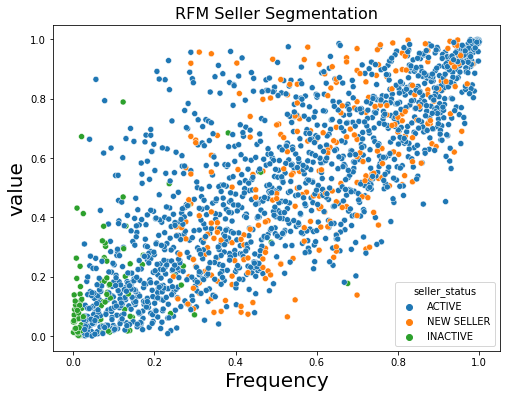

In [217]:
fig(8,6)
plt.title("RFM Seller Segmentation", size=16)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_sgmt_abt, x='frequency_rank', y='value_rank', hue='seller_status');

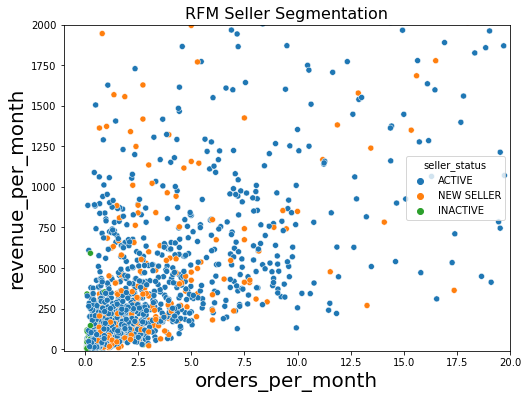

In [210]:
fig(8,6)
plt.title("RFM Seller Segmentation",  size=16)
plt.xlabel('orders_per_month', size=20)
plt.ylabel('revenue_per_month', size=20)
plt.ylim(-10, 2000)
plt.xlim(-1, 20)
sns.scatterplot(data=sellers_sgmt_abt, x='orders_per_month', y='revenue_per_month', hue='seller_status');

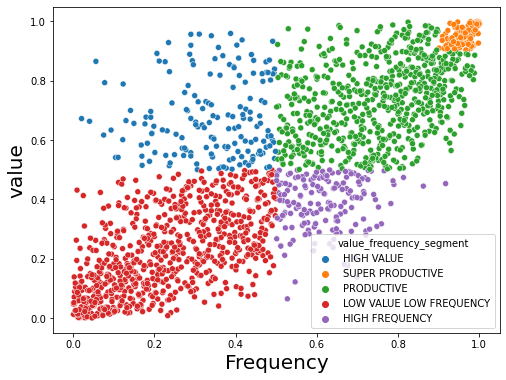

In [151]:
fig(8,6)
plt.xlabel('Frequency', size=20)
plt.ylabel('value', size=20)
sns.scatterplot(data=sellers_sgmt_abt, x='frequency_rank', y='value_rank', hue='value_frequency_segment');

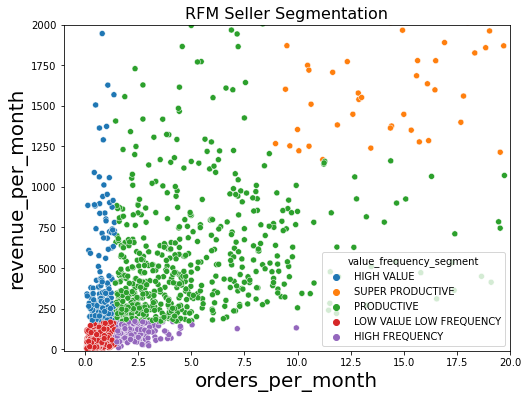

In [152]:
fig(8,6)
plt.title("RFM Seller Segmentation",  size=16)
plt.xlabel('orders_per_month', size=20)
plt.ylabel('revenue_per_month', size=20)
plt.ylim(-10, 2000)
plt.xlim(-1, 20)
sns.scatterplot(data=sellers_sgmt_abt, x='orders_per_month', y='revenue_per_month', hue='value_frequency_segment');

In [218]:
seller_status_df = pd.concat([sellers_sgmt_abt['seller_status'].value_counts(),
                              sellers_sgmt_abt['seller_status'].value_counts(normalize=True)],
                             axis=1)
seller_status_df.columns = ["quantity_of_sellers", "percentage"]
seller_status_df

,quantity_of_sellers,percentage
ACTIVE,1407,0.788677
NEW SELLER,279,0.156390
INACTIVE,98,0.054933


In [219]:
seller_rank_df = pd.concat([sellers_sgmt_abt['value_frequency_segment'].value_counts(),
                            sellers_sgmt_abt['value_frequency_segment'].value_counts(normalize=True)],
                           axis=1)

seller_rank_df.columns = ["quantity_of_sellers", "percentage"]
seller_rank_df

,quantity_of_sellers,percentage
LOW VALUE LOW FREQUENCY,723,0.405269
PRODUCTIVE,617,0.345852
HIGH FREQUENCY,169,0.094731
HIGH VALUE,168,0.094170
SUPER PRODUCTIVE,107,0.059978


In [155]:
sellers_stats = sellers_sgmt_abt.groupby("value_frequency_segment").agg(['mean','sum'])[['total_revenue','orders_quantity', 'orders_per_month', 'revenue_per_month']]

In [156]:
sellers_stats

total_revenue             orders_quantity         \
                                 mean         sum            mean    sum   
value_frequency_segment                                                    
HIGH FREQUENCY             623.236272   105326.93       14.224852   2404   
HIGH VALUE                2861.251190   480690.20        5.565476    935   
LOW VALUE LOW FREQUENCY    321.833651   232685.73        3.558783   2573   
PRODUCTIVE                4049.191572  2498351.20       35.544571  21931   
SUPER PRODUCTIVE         26514.789626  2837082.49      215.009346  23006   

                        orders_per_month              revenue_per_month  \
                                    mean          sum              mean   
value_frequency_segment                                                   
HIGH FREQUENCY                  2.410299   407.340546        105.087417   
HIGH VALUE                      0.846727   142.250170        466.537674   
LOW VALUE LOW FREQUENCY         0.551694   398.875093         47.826320   
PRODUCTIVE                      5.223375  3222.822301        657.545030   
SUPER PRODUCTIVE               27.257737  2916.577886       3556.111233   

                                        
                                   sum  
value_frequency_segment                 
HIGH FREQUENCY            17759.773547  
HIGH VALUE                78378.329213  
LOW VALUE LOW FREQUENCY   34578.429501  
PRODUCTIVE               405705.283573  
SUPER PRODUCTIVE         380503.901960

In [157]:
sellers_stats.index

Index(['HIGH FREQUENCY', 'HIGH VALUE', 'LOW VALUE LOW FREQUENCY', 'PRODUCTIVE',
       'SUPER PRODUCTIVE'],
      dtype='object', name='value_frequency_segment')

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


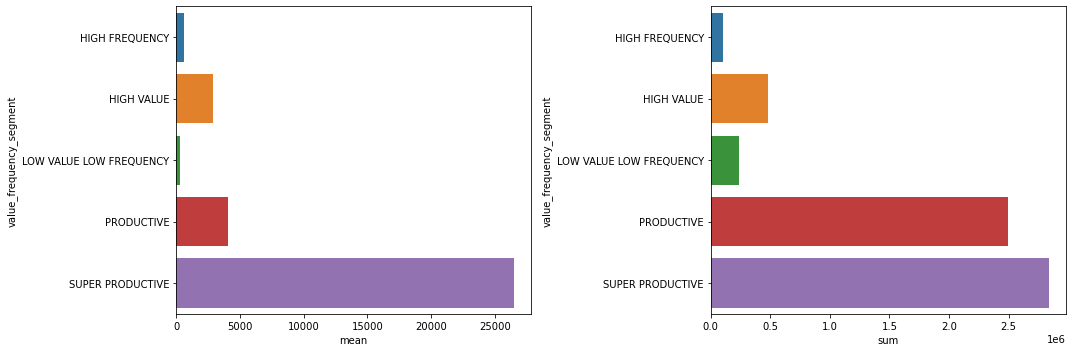

In [158]:
fig()
plt.subplot(1,2,1)
sns.barplot(sellers_stats['total_revenue']['mean'], sellers_stats.index)
plt.subplot(1,2,2)
sns.barplot(sellers_stats['total_revenue']['sum'], sellers_stats.index)
plt.tight_layout()

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


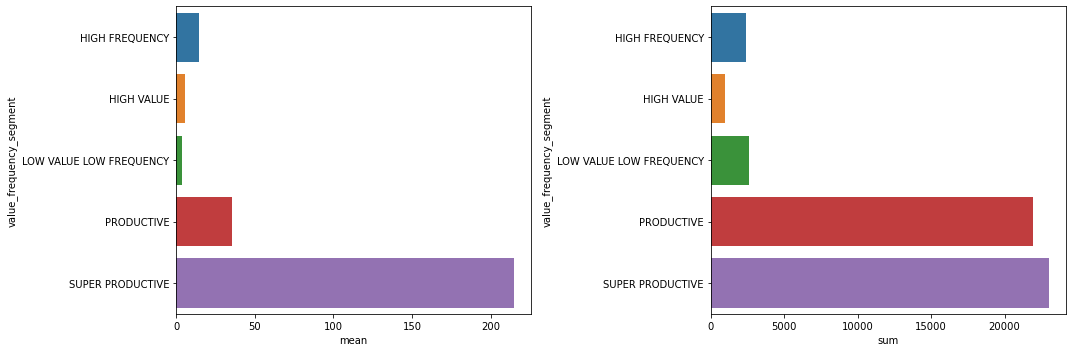

In [159]:
fig()
plt.subplot(1,2,1)
sns.barplot(sellers_stats['orders_quantity']['mean'], sellers_stats.index)
plt.subplot(1,2,2)
sns.barplot(sellers_stats['orders_quantity']['sum'], sellers_stats.index)
plt.tight_layout()

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


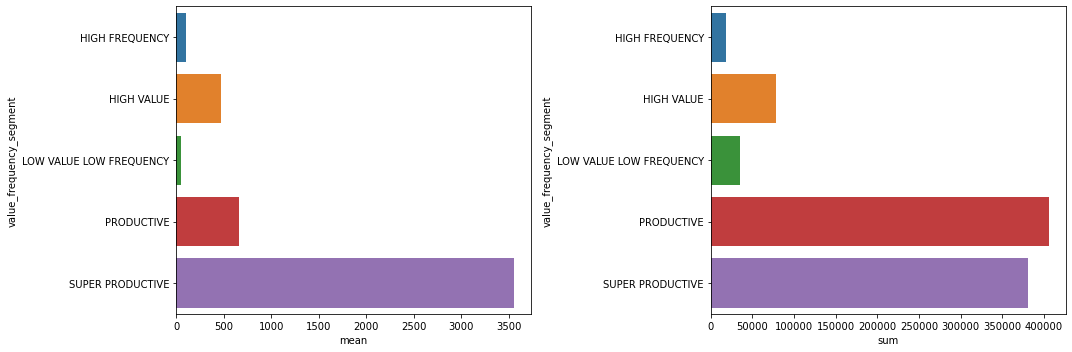

In [160]:
fig()
plt.subplot(1,2,1)
sns.barplot(sellers_stats['revenue_per_month']['mean'], sellers_stats.index)
plt.subplot(1,2,2)
sns.barplot(sellers_stats['revenue_per_month']['sum'], sellers_stats.index)
plt.tight_layout()

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


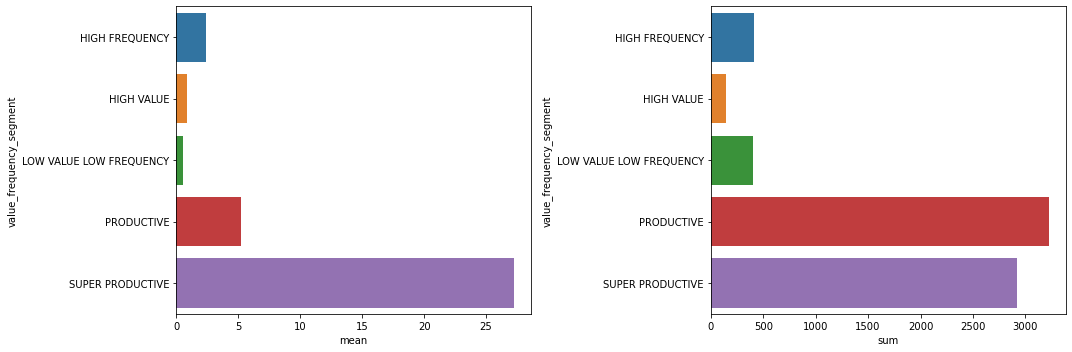

In [161]:
fig()
plt.subplot(1,2,1)
sns.barplot(sellers_stats['orders_per_month']['mean'], sellers_stats.index)
plt.subplot(1,2,2)
sns.barplot(sellers_stats['orders_per_month']['sum'], sellers_stats.index)
plt.tight_layout()

### 2.2 Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?

### 2.3 Is our product catalog comprehensive? Or does it focus on specific categories?

### 2.4 Do we always sell the same products? Or are there seasonalities?

In [21]:
# locations = pd.DataFrame(db.execute("SELECT geolocation_state, geolocation_lat, geolocation_lng FROM geolocation;"),
#                          columns=['state','lat','lng'])
# locations['region'] = locations.state.apply(map_regions)

# fig(15, 15)
# sns.scatterplot(data=locations, x='lng', y='lat', hue='region')
# plt.xlim(-75, -30)
# plt.ylim(-40, 10);


# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region


**We also need to know:**

> Number of Orders Per Day.
>
> Number of Orders per city.
>
> Number of Orders by Payment Method.

- What is the revenue for each product category? What about total sales, in units and in orders?
- What is the total amount of revenue generated by customers in each state? 
- What is the total amount of revenue generated by sellers in each state?

_delivered orders only_